In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

In [2]:
df_ori=pd.read_csv('YD1912_Uniquephosite.csv', index_col=0)

In [3]:
df_ori.columns

Index(['WTVeh_1', 'WTVeh_2', 'WTVeh_3', 'WTVeh_4', 'WTTx_1', 'WTTx_2',
       'WTTx_3', 'WTTx_4', 'KOVeh_1', 'KOVeh_2', 'KOVeh_3', 'KOVeh_4',
       'KOTx_1', 'KOTx_2', 'KOTx_3', 'KOTx_4'],
      dtype='object')

In [4]:
wt_v=['WTVeh_1', 'WTVeh_2', 'WTVeh_3', 'WTVeh_4']
wt_t=['WTTx_1', 'WTTx_2', 'WTTx_3', 'WTTx_4']
het_v=['KOVeh_1', 'KOVeh_2', 'KOVeh_3', 'KOVeh_4']
het_t=['KOTx_1', 'KOTx_2', 'KOTx_3', 'KOTx_4']

In [5]:
df_ori["mean_wt_v"]=df_ori[wt_v].mean(axis=1)
df_ori["mean_wt_t"]=df_ori[wt_t].mean(axis=1)
df_ori["mean_het_v"]=df_ori[het_v].mean(axis=1)
df_ori["mean_het_t"]=df_ori[het_t].mean(axis=1)

In [6]:
df_ori['log2FC_het_wt']=df_ori['mean_het_v']-df_ori['mean_wt_v']
df_ori['log2FC_wt_t_v']=df_ori['mean_wt_t']-df_ori['mean_wt_v']
df_ori['log2FC_het_t_v']=df_ori['mean_het_t']-df_ori['mean_het_v']

In [7]:
# Function to perform t-test for each row
def ttest_row(row, group_a, group_b):
    # Extract values for Group A and Group B for this row
    group_a_values = row[group_a].values
    group_b_values = row[group_b].values
    
    # Perform t-test for the two groups
    _, p_value = stats.ttest_ind(group_a_values, group_b_values)
    return p_value

In [8]:
# Apply the t-test row-wise and store p-values in a new column
df_ori['p_het_wt'] = df_ori.apply(ttest_row, axis=1, group_a=wt_v, group_b=het_v)
df_ori['p_wt_t_v'] = df_ori.apply(ttest_row, axis=1, group_a=wt_t, group_b=wt_v)
df_ori['p_het_t_v'] = df_ori.apply(ttest_row, axis=1, group_a=het_t, group_b=het_v)

In [9]:
df_ori['adjp_het_wt']  = multipletests(df_ori['p_het_wt'], method='fdr_bh')[1]
df_ori['adjp_wt_t_v']  = multipletests(df_ori['p_wt_t_v'], method='fdr_bh')[1]
df_ori['adjp_het_t_v']  = multipletests(df_ori['p_het_t_v'], method='fdr_bh')[1]

In [10]:
df_ori['-log10Pvalue_het_wt'] = -np.log10(df_ori['p_het_wt'])
df_ori['-log10Pvalue_wt_t_v'] = -np.log10(df_ori['p_wt_t_v'])
df_ori['-log10Pvalue_het_t_v'] = -np.log10(df_ori['p_het_t_v'])

In [11]:
df_ori['-log10adjPvalue_het_wt'] = -np.log10(df_ori['adjp_het_wt'])
df_ori['-log10adjPvalue_wt_t_v'] = -np.log10(df_ori['adjp_wt_t_v'])
df_ori['-log10adjPvalue_het_t_v'] = -np.log10(df_ori['adjp_het_t_v'])

In [12]:
sig_mask1 = (
    (abs(df_ori['log2FC_wt_t_v']) > 0.585) &
    (df_ori['-log10adjPvalue_wt_t_v'] > -np.log10(0.05))
)
df_ori_wt=df_ori.loc[sig_mask1]

In [14]:
sig_mask2 = (
    (abs(df_ori['log2FC_het_t_v']) > 0.585) &
    (df_ori['-log10adjPvalue_het_t_v'] > -np.log10(0.05))
)
df_ori_het=df_ori.loc[sig_mask2]

In [15]:
len(df_ori_wt), len(df_ori_het)

(363, 1033)

In [17]:
df_ori_wt.to_csv("F:/data science/Python/1 paper Rett proteomics/Figures/Fig 2/df_wt_363.csv")

In [18]:
df_ori_het.to_csv("F:/data science/Python/1 paper Rett proteomics/Figures/Fig 2/df_het_1033.csv")

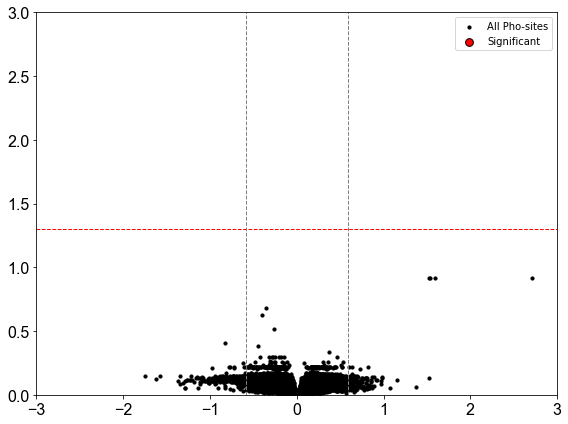

In [19]:
# Boolean mask for significant genes
sig_mask = (
    (abs(df_ori['log2FC_het_wt']) > 0.585) &
    (df_ori['-log10adjPvalue_het_wt'] > -np.log10(0.05))
)

# Base scatter: all genes
plt.figure(figsize=(8, 6))
plt.scatter(df_ori['log2FC_het_wt'], df_ori['-log10adjPvalue_het_wt'],
            c='black', alpha=1, edgecolors='k', s=10, label='All Pho-sites')

# Highlight significant ones
plt.scatter(df_ori.loc[sig_mask, 'log2FC_het_wt'], df_ori.loc[sig_mask, '-log10adjPvalue_het_wt'],
            c='red', edgecolors='k', s=60, label='Significant')

# Annotate gene names
for i, row in df_ori[sig_mask].iterrows():
    plt.text(row['log2FC_het_wt'], row['-log10adjPvalue_het_wt'], str(i),
             fontsize=8, ha='right', va='bottom')

# Reference lines
plt.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1)
plt.axvline(-0.585, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.585, color='gray', linestyle='--', linewidth=1)
plt.xlim(-3, 3)
plt.ylim(0, 3)
# Labels and title
#plt.title('het-wt adjusted p-value')
#plt.xlabel('log2 Fold Change')
#plt.ylabel('-log10(adjusted p-value)')
plt.xticks(fontsize=16, fontname='arial')
plt.yticks(fontsize=16, fontname='arial')
plt.legend()
plt.tight_layout()
#plt.savefig("F:/data science/Python/1 paper Rett proteomics/Figures/Fig 2/phosite_wt vs het.png", dpi=600)
plt.show()

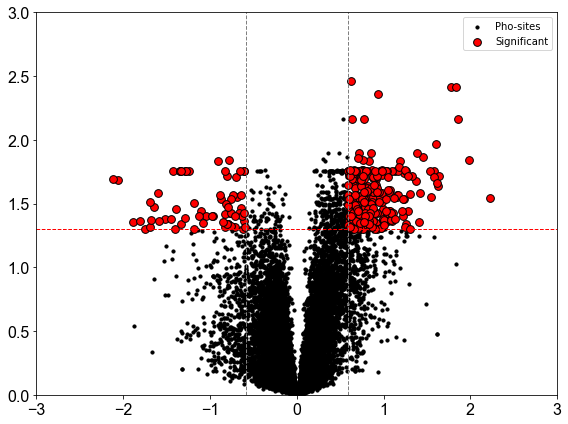

In [20]:
# focus on adjust pvalue and highlight significant ones
# Boolean mask for significant genes
sig_mask = (
    (abs(df_ori['log2FC_wt_t_v']) > 0.585) &
    (df_ori['-log10adjPvalue_wt_t_v'] > -np.log10(0.05))
)

# Base scatter: all genes
plt.figure(figsize=(8, 6))
plt.scatter(df_ori['log2FC_wt_t_v'], df_ori['-log10adjPvalue_wt_t_v'],
            c='black', alpha=1, edgecolors='k', s=10, label='Pho-sites')

# Highlight significant ones
plt.scatter(df_ori.loc[sig_mask, 'log2FC_wt_t_v'], df_ori.loc[sig_mask, '-log10adjPvalue_wt_t_v'],
            c='red', edgecolors='k', s=60, label='Significant')

# Annotate gene names
#for i, row in df[sig_mask].iterrows():
#    plt.text(row['log2FC_wt_t_v'], row['-log10adjPvalue_wt_t_v'], str(i),
#             fontsize=8, ha='right', va='bottom')

# Reference lines
plt.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1)
plt.axvline(-0.585, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.585, color='gray', linestyle='--', linewidth=1)
plt.xlim(-3, 3)
plt.ylim(0, 3)
# Labels and title
#plt.title('Different protein phosite between vehicle and treatment in wt mice')
#plt.xlabel('log2 Fold Change')
#plt.ylabel('-log10(adjusted p-value)')
plt.xticks(fontsize=16, fontname='arial')
plt.yticks(fontsize=16, fontname='arial')
plt.legend()
plt.tight_layout()
#plt.savefig("F:/data science/Python/1 paper Rett proteomics/Figures/Fig 2/phosite_wt-v vs wt-t.png", dpi=600)
plt.show()

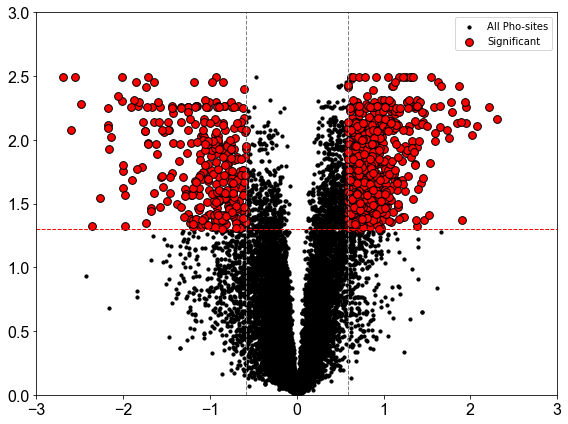

In [22]:
# focus on adjust pvalue and highlight significant ones
# Boolean mask for significant genes
sig_mask = (
    (abs(df_ori['log2FC_het_t_v']) > 0.585) &
    (df_ori['-log10adjPvalue_het_t_v'] > -np.log10(0.05))
)

# Base scatter: all genes
plt.figure(figsize=(8, 6))
plt.scatter(df_ori['log2FC_het_t_v'], df_ori['-log10adjPvalue_het_t_v'],
            c='black', alpha=1, edgecolors='k', s=10, label='All Pho-sites')

# Highlight significant ones
plt.scatter(df_ori.loc[sig_mask, 'log2FC_het_t_v'], df_ori.loc[sig_mask, '-log10adjPvalue_het_t_v'],
            c='red', edgecolors='k', s=60, label='Significant')

# Annotate gene names
#for i, row in df[sig_mask].iterrows():
#    plt.text(row['log2FC_wt_t_v'], row['-log10adjPvalue_wt_t_v'], str(i),
#             fontsize=8, ha='right', va='bottom')

# Reference lines
plt.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1)
plt.axvline(-0.585, color='gray', linestyle='--', linewidth=1)
plt.axvline(0.585, color='gray', linestyle='--', linewidth=1)
plt.xlim(-3, 3)
plt.ylim(0, 3)
plt.xticks(fontsize=16, fontname='arial')
plt.yticks(fontsize=16, fontname='arial')
plt.legend()
# Labels and title
#plt.title('Different protein phosite bewteen vehicle and treatment in het mice')
#plt.xlabel('log2 Fold Change')
#plt.ylabel('-log10(adjusted p-value)')
plt.tight_layout()
#plt.savefig("F:/data science/Python/1 paper Rett proteomics/Figures/Fig 2/phosite_het-v vs het-t.png", dpi=600)
plt.show()